In [ ]:
import pandas as pd

df = pd.read_csv("megares_fasta_processed.csv")
print("Unique drug classes in your dataset:")
print(sorted(df["drug_class"].dropna().unique().tolist()))

Unique drug classes in your dataset:
['Acetate_resistance', 'Acid_resistance', 'Aldehyde_resistance', 'Aluminum_resistance', 'Aminocoumarins', 'Aminoglycosides', 'Arsenic_resistance', 'Bacitracin', 'Biguanide_resistance', 'Biocide_and_metal_resistance', 'Cadmium_resistance', 'Cationic_antimicrobial_peptides', 'Chromium_resistance', 'Cobalt_resistance', 'Copper_resistance', 'Drug_and_biocide_and_metal_resistance', 'Drug_and_biocide_resistance', 'Drug_and_metal_resistance', 'Elfamycins', 'Fluoroquinolones', 'Fosfomycin', 'Fusidic_acid', 'Glycopeptides', 'Gold_resistance', 'Iron_resistance', 'Lead_resistance', 'Lipopeptides', 'MLS', 'Mercury_resistance', 'Metronidazole', 'Multi-biocide_resistance', 'Multi-drug_resistance', 'Multi-metal_resistance', 'Mupirocin', 'Mycobacterium_tuberculosis-specific_Drug', 'Naphthoquinone', 'Nickel_resistance', 'Nucleosides', 'Oxazolidinone', 'Pactamycin', 'Paraquat_resistance', 'Peroxide_resistance', 'Phenicol', 'Phenolic_compound_resistance', 'Pleuromutil

Loading CSV...
Total sequences: 8733
Held-out groups (243): ['AAK', 'ACC', 'ACI', 'ACT', 'ADC', 'AER', 'AFM', 'AIM', 'ALG', 'ALI', 'AMPC', 'AMPCR', 'AMPH', 'ANA', 'AQU', 'ARL', 'AST', 'AXC', 'AZECL', 'BAT'] ...
Non-heldout groups count: 1205
K-mer vocab size: 1224
db_train groups: 1205 db_test_held groups: 243 db_test_normal groups: 20
Input dim: 1224
Meta-training ProtoNet...


it 7800 loss 0.0009 acc 1.000: 100%|██████████| 8000/8000 [02:15<00:00, 58.87it/s]


ProtoNet K=1 held-out acc=0.9476 (se 0.0042) normal acc=0.9406
ProtoNet K=3 held-out acc=0.9600 (se 0.0039) normal acc=0.9648
ProtoNet K=5 held-out acc=0.9644 (se 0.0033) normal acc=0.9657
ProtoNet K=10 held-out acc=0.9662 (se 0.0031) normal acc=0.9728
Meta-training RidgeMeta...


it 7800 loss 1.0057 acc 0.733: 100%|██████████| 8000/8000 [02:20<00:00, 56.91it/s]


RidgeMeta K=1 held-out acc=0.9618 normal acc=0.9291
RidgeMeta K=3 held-out acc=0.9849 normal acc=0.9673
RidgeMeta K=5 held-out acc=0.9842 normal acc=0.9889
RidgeMeta K=10 held-out acc=0.9887 normal acc=0.9917
Meta-training RidgeMeta...


it 3800 loss 0.5619 acc 1.000: 100%|██████████| 4000/4000 [01:10<00:00, 56.65it/s]


BayesianMeta K=1 held-out acc=0.9693 normal acc=0.9314
BayesianMeta K=3 held-out acc=0.9820 normal acc=0.9714
BayesianMeta K=5 held-out acc=0.9850 normal acc=0.9840
BayesianMeta K=10 held-out acc=0.9884 normal acc=0.9921
Pretraining supervised on non-heldout classes ...
epoch 0 loss 6.5174
epoch 5 loss 5.4759
epoch 10 loss 4.7756
epoch 15 loss 4.0108
epoch 20 loss 3.4447
epoch 25 loss 2.9589
Supervised finetune K=1 acc@5steps=0.3773 (se 0.0155)
Supervised finetune K=3 acc@5steps=0.3640 (se 0.0185)
Supervised finetune K=5 acc@5steps=0.3813 (se 0.0190)
Supervised finetune K=10 acc@5steps=0.3929 (se 0.0206)
Saved accuracy_vs_K.png
Saved adaptation_supervised.png
Saved tsne_protonet_task.png
All done. Results saved in exp2_outputs
Summary (sample):
{'ProtoNet': {1: (np.float64(0.9475555693109831), np.float64(0.004188008962019465)), 3: (np.float64(0.9600000104308128), np.float64(0.0038618099510639883)), 5: (np.float64(0.964444457689921), np.float64(0.0032722797152744914)), 10: (np.float64(0

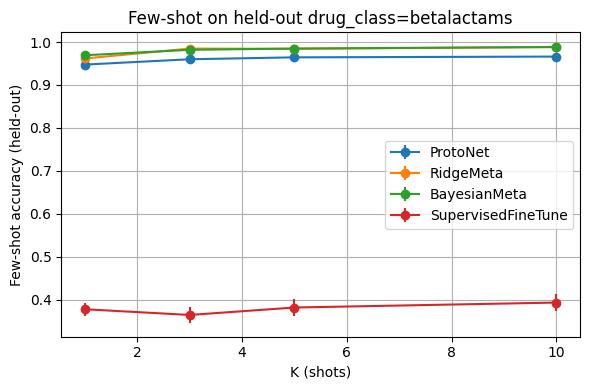

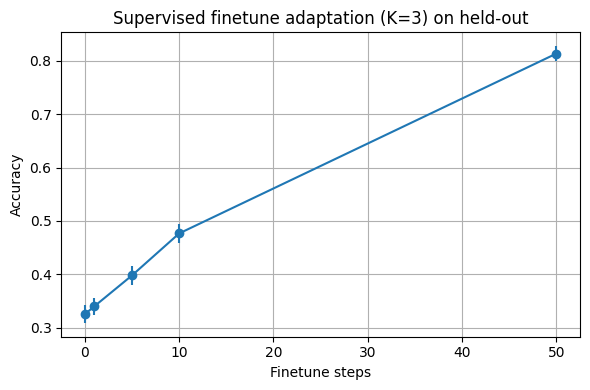

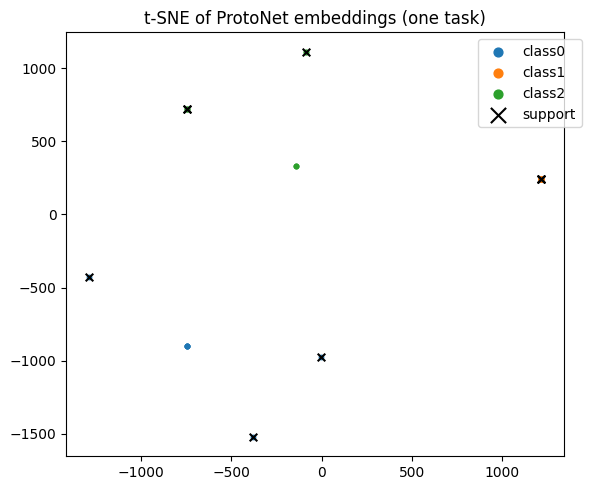

In [ ]:
#!/usr/bin/env python3

import os
import random
import math
from collections import Counter
from tqdm import trange, tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# -------------------------
# Config / paths / hyperparams
# -------------------------
CSV_PATH = "megares_fasta_processed.csv"  # file must contain the columns listed above
HOLDOUT_FIELD = "drug_class"  # choose 'drug_class' or 'mechanism' as holdout axis
HOLDOUT_NAME = "betalactams"   # change to the family you want to hold out
RANDOM_SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTDIR = "exp2_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# k-mer
KMER_K = 5
MAX_KMER_VOCAB = 20000

# Model / training
ENC_OUT_DIM = 128
ENC_HID = 512
META_ITERS = 8000      # increase for final runs
PROTO_LR = 1e-3
RIDGE_LR = 1e-3
PRETRAIN_EPOCHS = 30
BATCH_SIZE_PRETRAIN = 64

# Tasks
N_WAY = 3
Q_QUERY = 5
KS = [1, 3, 5, 10]
TEST_TASKS_PER_K = 600

# Supervised finetune params
FINETUNE_STEPS = [0, 1, 5, 10, 50]
FINETUNE_LR = 1e-3

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# -------------------------
# Utilities: load CSV, build k-mer vocab, vectorize
# -------------------------
def load_csv(path):
    df = pd.read_csv(path)
    required = {"gene_id","header","sequence","seq_len","gc_content","type","drug_class","mechanism","group"}
    if not required.issubset(set(df.columns)):
        raise ValueError(f"CSV missing required columns. Found: {df.columns.tolist()}")
    return df

def kmer_counts(seq, k=KMER_K):
    seq = str(seq).upper().replace("U", "T")
    counts = Counter()
    L = len(seq)
    for i in range(max(0, L - k + 1)):
        kmer = seq[i:i+k]
        if 'N' in kmer:
            continue
        counts[kmer] += 1
    return counts

def build_kmer_vocab(seqs, k=KMER_K, max_kmers=MAX_KMER_VOCAB):
    counts = Counter()
    for s in seqs:
        counts.update(kmer_counts(s, k))
    most = [k for k,_ in counts.most_common(max_kmers)]
    idx = {k:i for i,k in enumerate(most)}
    return idx

def vectorize_kmer(seq, kmer_idx, k=KMER_K):
    v = np.zeros(len(kmer_idx), dtype=np.float32)
    for kmer, cnt in kmer_counts(seq, k).items():
        i = kmer_idx.get(kmer, None)
        if i is not None:
            v[i] = cnt
    s = v.sum()
    if s > 0:
        v = v / s
    return v

# -------------------------
# Dataset organized by group (class)
# -------------------------
class GroupDatabase:
    def __init__(self, df, groups_list, kmer_idx):
        self.kmer_idx = kmer_idx
        self.groups = groups_list
        self.df = df
        self.group_to_seqs = {}
        for g in self.groups:
            rows = df[df['group'] == g]
            seqs = rows['sequence'].tolist()
            if len(seqs) < 1:
                continue
            self.group_to_seqs[g] = seqs
        self.groups = [g for g in self.groups if g in self.group_to_seqs]

    def group_counts(self):
        return {g: len(self.group_to_seqs[g]) for g in self.groups}

    def sample_task(self, N_way=N_WAY, K_shot=3, Q_query=Q_QUERY):
        classes = random.sample(self.groups, N_way)
        support_x, support_y, query_x, query_y = [], [], [], []
        for i, g in enumerate(classes):
            seqs = self.group_to_seqs[g]
            if len(seqs) < K_shot + Q_query:
                chosen = random.choices(seqs, k=K_shot + Q_query)
            else:
                chosen = random.sample(seqs, K_shot + Q_query)
            s = chosen[:K_shot]; q = chosen[K_shot:K_shot+Q_query]
            support_x += [vectorize_kmer(x, self.kmer_idx) for x in s]
            query_x += [vectorize_kmer(x, self.kmer_idx) for x in q]
            support_y += [i]*K_shot
            query_y += [i]*Q_query
        support_x = torch.tensor(np.stack(support_x)).float()
        query_x = torch.tensor(np.stack(query_x)).float()
        support_y = torch.tensor(support_y).long()
        query_y = torch.tensor(query_y).long()
        return support_x, support_y, query_x, query_y

# -------------------------
# Encoder & supervised wrapper
# -------------------------
class SmallEncoder(nn.Module):
    def __init__(self, input_dim, hid=ENC_HID, out_dim=ENC_OUT_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hid),
            nn.ReLU(),
            nn.Linear(hid, out_dim)
        )
    def forward(self, x):
        return self.net(x)

class SupervisedModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(ENC_OUT_DIM, num_classes)
    def forward(self, x):
        f = self.encoder(x)
        return self.classifier(f)

# -------------------------
# Prototypical functions
# -------------------------
def proto_loss_and_acc(s_features, s_y, q_features, q_y, N_way=N_WAY, K_shot=1):
    prototypes = []
    for c in range(N_way):
        cls_feats = s_features[s_y == c]
        prototypes.append(cls_feats.mean(dim=0))
    prototypes = torch.stack(prototypes)
    dists = torch.cdist(q_features, prototypes)
    logp = F.log_softmax(-dists, dim=1)
    loss = F.nll_loss(logp, q_y.to(logp.device))
    preds = logp.argmax(dim=1)
    acc = (preds == q_y.to(preds.device)).float().mean().item()
    return loss, acc

# -------------------------
# Ridge closed-form solver (differentiable)
# -------------------------
def ridge_closed_form_classifier(s_feats, s_y, N_way, K_shot, lambda_reg=1.0):
    device = s_feats.device
    D = s_feats.size(1)
    NK = s_feats.size(0)
    Y = torch.zeros(NK, N_way, device=device)
    for i in range(NK):
        Y[i, s_y[i]] = 1.0
    X = s_feats
    XtX = X.t().mm(X)
    reg = lambda_reg * torch.eye(D, device=device)
    A = XtX + reg
    # small jitter for numerical stability
    A = A + 1e-6 * torch.eye(D, device=device)
    rhs = X.t().mm(Y)
    W = torch.linalg.solve(A, rhs)

    return W

def ridge_predict(W, q_feats):
    logits = q_feats.mm(W)
    return logits

# -------------------------
# Bayesian posterior predictive (practical)
# -------------------------
def bayesian_posterior(s_feats, s_y, N_way, K_shot, prior_var=1.0, noise_var=1.0):
    device = s_feats.device
    D = s_feats.size(1)
    NK = s_feats.size(0)
    Y = torch.zeros(NK, N_way, device=device)
    for i in range(NK):
        Y[i, s_y[i]] = 1.0
    X = s_feats
    XtX = X.t().mm(X)
    Sigma_inv = (1.0 / noise_var) * XtX + (1.0 / prior_var) * torch.eye(D, device=device)
    rhs = (1.0 / noise_var) * X.t().mm(Y)
    W_mean = torch.linalg.solve(Sigma_inv, rhs)
    Sigma = torch.linalg.inv(Sigma_inv)
    return W_mean, Sigma

def bayesian_predict(W_mean, Sigma, q_feats):
    logits_mean = q_feats.mm(W_mean)
    q_Sigma = (q_feats.mm(Sigma) * q_feats).sum(dim=1, keepdim=True)
    scale = torch.sqrt(q_Sigma + 1e-8)
    logits = logits_mean / (1.0 + scale)
    return logits

# -------------------------
# Meta-training loops
# -------------------------
def meta_train_protonet(encoder, db_train, iters= META_ITERS, lr=PROTO_LR, device=DEVICE):
    encoder.to(device)
    opt = torch.optim.Adam(encoder.parameters(), lr=lr)
    print("Meta-training ProtoNet...")
    pbar = trange(iters)
    for it in pbar:
        s_x, s_y, q_x, q_y = db_train.sample_task()
        s_x = s_x.to(device); q_x = q_x.to(device)
        s_y = s_y.to(device); q_y = q_y.to(device)
        enc_s = encoder(s_x)
        enc_q = encoder(q_x)
        loss, acc = proto_loss_and_acc(enc_s, s_y, enc_q, q_y)
        opt.zero_grad(); loss.backward(); opt.step()
        if it % 200 == 0:
            pbar.set_description(f"it {it} loss {loss.item():.4f} acc {acc:.3f}")
    return encoder

def meta_train_ridgemeta(encoder, db_train, iters= META_ITERS, lr=RIDGE_LR, lambda_reg=1.0, device=DEVICE):
    encoder.to(device)
    opt = torch.optim.Adam(encoder.parameters(), lr=lr)
    print("Meta-training RidgeMeta...")
    pbar = trange(iters)
    for it in pbar:
        s_x, s_y, q_x, q_y = db_train.sample_task()
        s_x = s_x.to(device); q_x = q_x.to(device)
        s_y = s_y.to(device); q_y = q_y.to(device)
        enc_s = encoder(s_x)
        enc_q = encoder(q_x)
        W = ridge_closed_form_classifier(enc_s, s_y, N_way=N_WAY, K_shot=(len(s_y)//N_WAY), lambda_reg=lambda_reg)
        logits = ridge_predict(W, enc_q)
        loss = F.cross_entropy(logits, q_y.to(logits.device))
        preds = logits.argmax(dim=1)
        acc = (preds == q_y.to(preds.device)).float().mean().item()
        opt.zero_grad(); loss.backward(); opt.step()
        if it % 200 == 0:
            pbar.set_description(f"it {it} loss {loss.item():.4f} acc {acc:.3f}")
    return encoder

# -------------------------
# Supervised pretrain
# -------------------------
def pretrain_supervised(encoder, df_nonheld, kmer_idx, epochs=PRETRAIN_EPOCHS, batch_size=BATCH_SIZE_PRETRAIN):
    groups = sorted(df_nonheld['group'].unique().tolist())
    if len(groups) == 0:
        raise ValueError("No non-heldout groups for supervised pretraining.")
    le = LabelEncoder()
    le.fit(groups)
    X = []
    y = []
    for _, row in df_nonheld.iterrows():
        g = row['group']
        seq = row['sequence']
        X.append(vectorize_kmer(seq, kmer_idx))
        y.append(int(le.transform([g])[0]))
    X = np.stack(X)
    y = np.array(y)
    X_t = torch.tensor(X).float()
    y_t = torch.tensor(y).long()
    dataset = torch.utils.data.TensorDataset(X_t, y_t)
    dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = SupervisedModel(encoder, num_classes=len(groups)).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    print("Pretraining supervised on non-heldout classes ...")
    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        tot = 0
        for bx, by in dl:
            bx=bx.to(DEVICE); by=by.to(DEVICE)
            logits = model(bx)
            loss = loss_fn(logits, by)
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item() * bx.size(0)
            tot += bx.size(0)
        if ep % 5 == 0:
            print(f"epoch {ep} loss {total_loss/tot:.4f}")
    return model, le

# -------------------------
# Evaluation helpers
# -------------------------
@torch.no_grad()
def evaluate_fewshot_proto(encoder, db_test, K_shot, tasks=200):
    encoder.eval()
    accs = []
    for _ in range(tasks):
        s_x, s_y, q_x, q_y = db_test.sample_task(K_shot=K_shot)
        s_x = s_x.to(DEVICE); q_x = q_x.to(DEVICE)
        s_y = s_y.to(DEVICE); q_y = q_y.to(DEVICE)
        enc_s = encoder(s_x); enc_q = encoder(q_x)
        loss, acc = proto_loss_and_acc(enc_s, s_y, enc_q, q_y)
        accs.append(acc)
    return np.mean(accs), np.std(accs)/math.sqrt(len(accs))

@torch.no_grad()
def evaluate_fewshot_ridgemeta(encoder, db_test, K_shot, tasks=200, lambda_reg=1.0):
    encoder.eval()
    accs = []
    for _ in range(tasks):
        s_x, s_y, q_x, q_y = db_test.sample_task(K_shot=K_shot)
        s_x = s_x.to(DEVICE); q_x = q_x.to(DEVICE)
        s_y = s_y.to(DEVICE); q_y = q_y.to(DEVICE)
        enc_s = encoder(s_x); enc_q = encoder(q_x)
        W = ridge_closed_form_classifier(enc_s, s_y, N_way=N_WAY, K_shot=K_shot, lambda_reg=lambda_reg)
        logits = ridge_predict(W, enc_q)
        preds = logits.argmax(dim=1)
        acc = (preds == q_y.to(preds.device)).float().mean().item()
        accs.append(acc)
    return np.mean(accs), np.std(accs)/math.sqrt(len(accs))

@torch.no_grad()
def evaluate_fewshot_bayesian(encoder, db_test, K_shot, tasks=200):
    encoder.eval()
    accs = []
    for _ in range(tasks):
        s_x, s_y, q_x, q_y = db_test.sample_task(K_shot=K_shot)
        s_x = s_x.to(DEVICE); q_x = q_x.to(DEVICE)
        s_y = s_y.to(DEVICE); q_y = q_y.to(DEVICE)
        enc_s = encoder(s_x); enc_q = encoder(q_x)
        W_mean, Sigma = bayesian_posterior(enc_s, s_y, N_way=N_WAY, K_shot=K_shot, prior_var=1.0, noise_var=1.0)
        logits = bayesian_predict(W_mean, Sigma, enc_q)
        preds = logits.argmax(dim=1)
        acc = (preds == q_y.to(preds.device)).float().mean().item()
        accs.append(acc)
    return np.mean(accs), np.std(accs)/math.sqrt(len(accs))

# Finetune supervised baseline per task
def finetune_and_eval_supervised(pretrained_model, db_test, K_shot, steps=5, lr=FINETUNE_LR):
    # create new head (N_way) and optionally finetune encoder
    device = DEVICE
    encoder = pretrained_model.encoder.to(device)
    new_head = nn.Linear(ENC_OUT_DIM, N_WAY).to(device)
    # set encoder trainable (or freeze if you want only head training)
    for p in encoder.parameters():
        p.requires_grad = True
    params = list(encoder.parameters()) + list(new_head.parameters())
    opt = torch.optim.SGD(params, lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    s_x, s_y, q_x, q_y = db_test.sample_task(K_shot=K_shot)
    s_x = s_x.to(device); q_x = q_x.to(device)
    s_y = s_y.to(device); q_y = q_y.to(device)
    accs = {}
    for step in range(steps+1):
        with torch.no_grad():
            enc_q = encoder(q_x)
            logits_q = enc_q.mm(new_head.weight.t()) + new_head.bias
            preds = logits_q.argmax(dim=1)
            acc = (preds == q_y.to(preds.device)).float().mean().item()
            accs[step] = acc
        if step == steps:
            break
        encoder.train(); new_head.train()
        enc_s = encoder(s_x)
        logits_s = enc_s.mm(new_head.weight.t()) + new_head.bias
        loss = loss_fn(logits_s, s_y)
        opt.zero_grad(); loss.backward(); opt.step()
    return accs

def adaptation_curve_supervised(pretrained_model, db_test, K_shot, steps_list=FINETUNE_STEPS, tasks=100):
    all_curve = {s: [] for s in steps_list}
    for _ in range(tasks):
        accs = finetune_and_eval_supervised(pretrained_model, db_test, K_shot, steps=max(steps_list))
        for s in steps_list:
            all_curve[s].append(accs[s])
    mean_curve = {s: (np.mean(all_curve[s]), np.std(all_curve[s])/math.sqrt(len(all_curve[s]))) for s in steps_list}
    return mean_curve

# -------------------------
# t-SNE helper
# -------------------------
@torch.no_grad()
def compute_embedding_before_after(encoder, db_test, K_shot=3):
    s_x, s_y, q_x, q_y = db_test.sample_task(K_shot=K_shot)
    x = torch.cat([s_x, q_x], dim=0).to(DEVICE)
    encoder.eval()
    feats = encoder(x).cpu().numpy()
    labels = np.concatenate([s_y.numpy(), q_y.numpy()])
    is_support = np.array([1]*(len(s_y)) + [0]*(len(q_y)))
    return feats, labels, is_support

# -------------------------
# Main experiment flow
# -------------------------
def run_experiment():
    print("Loading CSV...")
    df = load_csv(CSV_PATH)
    print("Total sequences:", len(df))

    # Determine groups to hold out
    held_groups = sorted(df[df[HOLDOUT_FIELD] == HOLDOUT_NAME]['group'].unique().tolist())
    if len(held_groups) == 0:
        raise ValueError(f"No groups found for held-out {HOLDOUT_FIELD}={HOLDOUT_NAME}. Check CSV or pick another holdout.")
    print(f"Held-out groups ({len(held_groups)}): {held_groups[:20]} ...")

    # non-heldout groups
    nonheld_df = df[~(df[HOLDOUT_FIELD] == HOLDOUT_NAME)].copy()
    nonheld_groups = sorted(nonheld_df['group'].unique().tolist())
    print(f"Non-heldout groups count: {len(nonheld_groups)}")

    # Build kmer vocab from non-heldout sequences
    kmer_vocab = build_kmer_vocab(nonheld_df['sequence'].tolist(), k=KMER_K, max_kmers=MAX_KMER_VOCAB)
    print("K-mer vocab size:", len(kmer_vocab))

    # Create GroupDatabases
    db_train = GroupDatabase(nonheld_df, nonheld_groups, kmer_vocab)
    db_test_held = GroupDatabase(df[df[HOLDOUT_FIELD] == HOLDOUT_NAME], held_groups, kmer_vocab)
    test_normal_groups = random.sample(nonheld_groups, max(1, min(20, len(nonheld_groups)//5)))
    db_test_normal = GroupDatabase(df[df['group'].isin(test_normal_groups)], test_normal_groups, kmer_vocab)
    print("db_train groups:", len(db_train.groups), "db_test_held groups:", len(db_test_held.groups), "db_test_normal groups:", len(db_test_normal.groups))

    input_dim = len(kmer_vocab)
    print("Input dim:", input_dim)

    # ---------- ProtoNet ----------
    proto_encoder = SmallEncoder(input_dim=input_dim).to(DEVICE)
    proto_encoder = meta_train_protonet(proto_encoder, db_train, iters=META_ITERS, lr=PROTO_LR)
    results = {"ProtoNet": {}}
    for K in KS:
        mean_acc, se = evaluate_fewshot_proto(proto_encoder, db_test_held, K_shot=K, tasks=TEST_TASKS_PER_K)
        results["ProtoNet"][K] = (mean_acc, se)
        mn2, se2 = evaluate_fewshot_proto(proto_encoder, db_test_normal, K_shot=K, tasks=TEST_TASKS_PER_K)
        print(f"ProtoNet K={K} held-out acc={mean_acc:.4f} (se {se:.4f}) normal acc={mn2:.4f}")
    torch.save(proto_encoder.state_dict(), os.path.join(OUTDIR, "proto_encoder.pt"))

    # ---------- RidgeMeta ----------
    ridge_encoder = SmallEncoder(input_dim=input_dim).to(DEVICE)
    ridge_encoder = meta_train_ridgemeta(ridge_encoder, db_train, iters=META_ITERS, lr=RIDGE_LR, lambda_reg=1.0)
    results["RidgeMeta"] = {}
    for K in KS:
        mean_acc, se = evaluate_fewshot_ridgemeta(ridge_encoder, db_test_held, K_shot=K, tasks=TEST_TASKS_PER_K)
        results["RidgeMeta"][K] = (mean_acc, se)
        mn2, se2 = evaluate_fewshot_ridgemeta(ridge_encoder, db_test_normal, K_shot=K, tasks=TEST_TASKS_PER_K)
        print(f"RidgeMeta K={K} held-out acc={mean_acc:.4f} normal acc={mn2:.4f}")
    torch.save(ridge_encoder.state_dict(), os.path.join(OUTDIR, "ridge_encoder.pt"))

    # ---------- Bayesian Meta ----------
    bayes_encoder = SmallEncoder(input_dim=input_dim).to(DEVICE)
    bayes_encoder = meta_train_ridgemeta(bayes_encoder, db_train, iters=int(META_ITERS//2), lr=RIDGE_LR, lambda_reg=1.0)
    results["BayesianMeta"] = {}
    for K in KS:
        mean_acc, se = evaluate_fewshot_bayesian(bayes_encoder, db_test_held, K_shot=K, tasks=TEST_TASKS_PER_K)
        results["BayesianMeta"][K] = (mean_acc, se)
        mn2, se2 = evaluate_fewshot_bayesian(bayes_encoder, db_test_normal, K_shot=K, tasks=TEST_TASKS_PER_K)
        print(f"BayesianMeta K={K} held-out acc={mean_acc:.4f} normal acc={mn2:.4f}")
    torch.save(bayes_encoder.state_dict(), os.path.join(OUTDIR, "bayes_encoder.pt"))

    # ---------- Supervised baseline ----------
    sup_encoder = SmallEncoder(input_dim=input_dim)
    pretrained_model, label_encoder = pretrain_supervised(sup_encoder, nonheld_df, kmer_vocab, epochs=PRETRAIN_EPOCHS)
    torch.save(pretrained_model.state_dict(), os.path.join(OUTDIR, "supervised_pretrained.pt"))

    results["SupervisedFineTune"] = {}
    for K in KS:
        curve = adaptation_curve_supervised(pretrained_model, db_test_held, K_shot=K, steps_list=FINETUNE_STEPS, tasks=150)
        acc5, se5 = curve.get(5, (None, None))
        results["SupervisedFineTune"][K] = (acc5, se5)
        print(f"Supervised finetune K={K} acc@5steps={acc5:.4f} (se {se5:.4f})")

    # ---------- Save & plot ----------
    import json
    with open(os.path.join(OUTDIR, "results.json"), "w") as f:
        json.dump(results, f, indent=2)

    plt.figure(figsize=(6,4))
    for model_name in results:
        means = [results[model_name][K][0] for K in KS]
        ses = [results[model_name][K][1] for K in KS]
        plt.errorbar(KS, means, yerr=ses, label=model_name, marker='o')
    plt.xlabel("K (shots)")
    plt.ylabel("Few-shot accuracy (held-out)")
    plt.title(f"Few-shot on held-out {HOLDOUT_FIELD}={HOLDOUT_NAME}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "accuracy_vs_K.png"))
    print("Saved accuracy_vs_K.png")

    K_plot = 3
    sup_curve = adaptation_curve_supervised(pretrained_model, db_test_held, K_shot=K_plot, steps_list=FINETUNE_STEPS, tasks=200)
    steps = sorted(sup_curve.keys())
    means = [sup_curve[s][0] for s in steps]
    ses = [sup_curve[s][1] for s in steps]
    plt.figure(figsize=(6,4))
    plt.errorbar(steps, means, yerr=ses, marker='o')
    plt.xlabel("Finetune steps")
    plt.ylabel("Accuracy")
    plt.title(f"Supervised finetune adaptation (K={K_plot}) on held-out")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "adaptation_supervised.png"))
    print("Saved adaptation_supervised.png")

    # replace your TSNE call with a safe perplexity
    feats, labels, is_support = compute_embedding_before_after(proto_encoder, db_test_held, K_shot=3)
    n_samples = feats.shape[0]
    perp = max(1, min(30, (n_samples - 1) // 3))
    tsne = TSNE(n_components=2, perplexity=perp, random_state=RANDOM_SEED)
    z = tsne.fit_transform(feats)

    plt.figure(figsize=(6,5))
    for c in np.unique(labels):
        idx = labels == c
        plt.scatter(z[idx,0], z[idx,1], label=f"class{c}", s=10)
    plt.scatter(z[is_support==1,0], z[is_support==1,1], marker='x', s=30, c='k', label='support')
    plt.legend(markerscale=2, bbox_to_anchor=(1.05,1))
    plt.title("t-SNE of ProtoNet embeddings (one task)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "tsne_protonet_task.png"))
    print("Saved tsne_protonet_task.png")

    print("All done. Results saved in", OUTDIR)
    print("Summary (sample):")
    print(results)

if __name__ == "__main__":
    run_experiment()
